<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <img src="../images/QWorld.png"> </td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by <a href="https://gitlab.com/pjr1363" target="_blank"> Paul Joseph Robin </a></td>
    </tr> 
 </table>
 
<hr>

##  Solutions for Higher Order Problems

<a id="Task1"></a>
### Task 1

The objective function is:
$$f (x_1, x_2, x_3) = 5x_1 + 7x_1 x_2 - 3x_1 x_2 x_3$$

Let $y_{23}$ := $x_2 x_3$. So by Rosenberg's method, the quadratic objective function becomes
$$f (x_1, x_2, y_{23}) = 5x_1 + 7x_1 x_2 - 3x_1 y_{23} + C (x_2x_3 - 2x_2y_{23} - 2x_3 y_{23} + 3y_{23} )$$ 

> It can be verified that this indeed satisfies the constraint $x_2x_3 = y_{23}$:
>
> Let $y_{23} = x_2x_3 = 1$
>
> $\Rightarrow x_2 = 1, x_3 = 1$, which leads to the penalty term being zero.



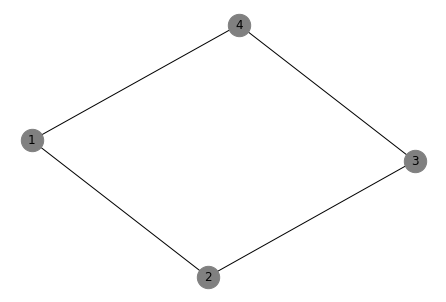

In [13]:
import networkx as nx

edges = [(1, 2), (2, 3), (3, 4), (4, 1)]
G = nx.Graph( )
G.add_edges_from( edges )  # Create a Graph from the given edges

color_map = ['grey']    
nx.draw(G, with_labels=True, node_color = color_map, node_size = 500)

In [32]:
import numpy as np

def Np(coord, K):  # New coordinate
    i, p = coord
    return (i - 1)*K + p

def objectiveFunction(G, K, P):
    N = len(G.nodes) 
    n = K*N  # Dimension of QUBO Matrix

    Q = np.zeros((n, n))

    ### Constraint 2 ###
    for i, j in G.edges:
        if i > j:    # Enforce upper-triangular representation
            temp = i; i = j; j = temp

        for p in range(1, K+1):
            c1 = Np((i, p), K)
            c2 = Np((j, p), K)
            Q[c1-1][c2-1] = P  # Array at 0

    ### Constraint 1 ###
    for i in range(n-1):
        Q[i][i] = -P

        factor = i    # ie, an integer (ideally i-1, however i in this loop is from 0)
        if (factor%K == 0):
            Q[i][i+1] = 2*P
            #Q[i][i+2] = 2*P
        else:
            Q[i][i+1] = 2*P
    Q[n-1][n-1] = -P        # Not covered in the loop

    return Q
# Offset of N*P is added in bqm below

In [47]:
from dimod import BinaryQuadraticModel

P = 50
K = 2    # Number of colors
N = len(G.nodes)
Q = objectiveFunction(G, K, P)
bqm_qubo = BinaryQuadraticModel.from_numpy_matrix(Q, offset = P*(N))
Q

array([[-50., 100.,  50.,   0.,   0.,   0.,  50.,   0.],
       [  0., -50., 100.,  50.,   0.,   0.,   0.,  50.],
       [  0.,   0., -50., 100.,  50.,   0.,   0.,   0.],
       [  0.,   0.,   0., -50., 100.,  50.,   0.,   0.],
       [  0.,   0.,   0.,   0., -50., 100.,  50.,   0.],
       [  0.,   0.,   0.,   0.,   0., -50., 100.,  50.],
       [  0.,   0.,   0.,   0.,   0.,   0., -50., 100.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -50.]])

In [48]:
N

4

In [49]:
from dimod.reference.samplers import ExactSolver

sampler = ExactSolver()
sampleset = sampler.sample(bqm_qubo)

print(sampleset);

     0  1  2  3  4  5  6  7 energy num_oc.
225  1  0  0  0  1  0  0  1   50.0       1
241  1  0  0  1  0  0  0  1   50.0       1
14   1  0  0  1  0  0  0  0  100.0       1
28   0  1  0  0  1  0  0  0  100.0       1
30   1  0  0  0  1  0  0  0  100.0       1
49   1  0  0  1  0  1  0  0  100.0       1
56   0  0  1  0  0  1  0  0  100.0       1
57   1  0  1  0  0  1  0  0  100.0       1
60   0  1  0  0  0  1  0  0  100.0       1
62   1  0  0  0  0  1  0  0  100.0       1
99   0  1  0  0  1  0  1  0  100.0       1
112  0  0  0  1  0  0  1  0  100.0       1
113  1  0  0  1  0  0  1  0  100.0       1
115  0  1  0  1  0  0  1  0  100.0       1
120  0  0  1  0  0  0  1  0  100.0       1
124  0  1  0  0  0  0  1  0  100.0       1
193  1  0  0  0  0  1  0  1  100.0       1
198  1  0  1  0  0  1  0  1  100.0       1
199  0  0  1  0  0  1  0  1  100.0       1
206  1  0  0  1  0  1  0  1  100.0       1
224  0  0  0  0  1  0  0  1  100.0       1
227  0  1  0  0  1  0  0  1  100.0       1
230  1  0  

In [50]:
print(sampleset.lowest())
print("\nThe lowest energy is ", sampleset.first.energy)

   0  1  2  3  4  5  6  7 energy num_oc.
0  1  0  0  0  1  0  0  1   50.0       1
1  1  0  0  1  0  0  0  1   50.0       1
['BINARY', 2 rows, 2 samples, 8 variables]

The lowest energy is  50.0


It is observed that for values of $C$ less than $4$, we get a 'false positive', ie, the assignment $(1, 0, 1)$ returns the lowest energy configuration despite not satisfying the constraint $x_2x_3 = y_{23}$. It can easily be visualized that $C = 4$ is the correct penalty value satisfying the constraints.

---